In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import itertools
import time

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, \
make_scorer
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from patsy import dmatrix
from pyearth import Earth

In [714]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [715]:
train.shape

(5380, 767)

In [716]:
test.shape

(4403, 766)

In [717]:
train.isna().any().sum()

473

In [718]:
test.isna().any().sum()

480

## Data Cleaning

### Visualizing NaN columns

In [719]:
# Drop columns with more than 5% missing values
train.shape[0]*0.05

269.0

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f8ed5edc310>
Traceback (most recent call last):
  File "/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


Text(0.5, 1.0, 'Columns with NaN values > 269')

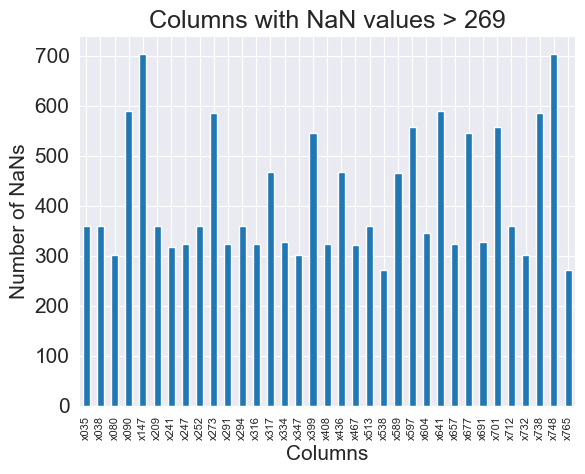

In [451]:
nan_cols[nan_cols > 269]
fig, ax = plt.subplots()
sns.set_style("darkgrid")
nan_cols[nan_cols > 269].plot(kind='bar', ax=ax)
plt.tick_params(axis='x', labelsize=8)
ax.set_xlabel('Columns')
ax.set_ylabel('Number of NaNs')
ax.set_title('Columns with NaN values > 269')

In [721]:
nan_cols = test.isna().sum()
test1 = test.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)
train1 = train.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)

In [722]:
from sklearn.impute import KNNImputer
import pandas as pd

imputer = KNNImputer(n_neighbors=3)

# fit and transform the data
test_imputed = pd.DataFrame(imputer.fit_transform(test1), columns=test1.columns)
train_imputed = pd.DataFrame(imputer.fit_transform(train1), columns=train1.columns)

### Correlation

In [661]:
corr_y = train_imputed.corrwith(train_imputed['y'])
top_30 = corr_y.abs().sort_values(ascending = False)[0:30]

In [723]:
corr_y_series = train_imputed.corrwith(train_imputed['y']).abs().sort_values(ascending = False)

In [724]:
corr_y_series[corr_y_series.isna()]

x063   NaN
x137   NaN
x255   NaN
x385   NaN
x405   NaN
x453   NaN
x465   NaN
x518   NaN
x594   NaN
x643   NaN
x703   NaN
dtype: float64

In [634]:
corr_matrix = train_imputed.corr().abs()

In [560]:
corr_matrix

id      x001      x002      x003      x004      x005      x006  \
id    1.000000  0.014591  0.001859  0.002327  0.004353  0.024598  0.014469   
x001  0.014591  1.000000  0.102535  0.154786  0.379671  0.493368  0.246621   
x002  0.001859  0.102535  1.000000  0.177968  0.035330  0.180151  0.071401   
x003  0.002327  0.154786  0.177968  1.000000  0.065973  0.050223  0.112701   
x004  0.004353  0.379671  0.035330  0.065973  1.000000  0.231332  0.222151   
...        ...       ...       ...       ...       ...       ...       ...   
x761  0.000953  0.601803  0.007468  0.159693  0.186038  0.007842  0.148491   
x762  0.018700  0.057966  0.101310  0.234714  0.046514  0.042271  0.098490   
x763  0.009983  0.628169  0.017972  0.204024  0.225874  0.128953  0.226026   
x764  0.006915  0.150038  0.819504  0.501020  0.086248  0.026678  0.116055   
y     0.018863  0.002827  0.065831  0.200914  0.021558  0.060271  0.122274   

          x007      x008      x009  ...      x756      x757      x758  \
id    0.003621  0.001677  0.023309  ...  0.000281  0.014413  0.009485   
x001  0.165825  0.103875  0.032141  ...  0.010729  0.052280  0.004880   
x002  0.463696  0.961173  0.103448  ...  0.016781  0.058053  0.104158   
x003  0.500108  0.198119  0.177705  ...  0.089311  0.252027  0.137720   
x004  0.126814  0.075785  0.038897  ...  0.018000  0.082101  0.021076   
...        ...       ...       ...  ...       ...       ...       ...   
x761  0.144259  0.037001  0.070091  ...  0.081181  0.085836  0.064229   
x762  0.364691  0.150668  0.942297  ...  0.040264  0.840947  0.228044   
x763  0.154845  0.019048  0.084949  ...  0.058851  0.100417  0.086515   
x764  0.741642  0.853029  0.244357  ...  0.046010  0.250692  0.210115   
y     0.109799  0.074529  0.050124  ...  0.312310  0.059782  0.107359   

          x759      x760      x761      x762      x763      x764         y  
id    0.008520  0.018878  0.000953  0.018700  0.009983  0.006915  0.018863  
x001  0.016304  0.057322  0.601803  0.057966  0.628169  0.150038  0.002827  
x002  0.045611  0.102379  0.007468  0.101310  0.017972  0.819504  0.065831  
x003  0.092020  0.232173  0.159693  0.234714  0.204024  0.501020  0.200914  
x004  0.011298  0.044657  0.186038  0.046514  0.225874  0.086248  0.021558  
...        ...       ...       ...       ...       ...       ...       ...  
x761  0.031090  0.080232  1.000000  0.082230  0.794701  0.134074  0.019237  
x762  0.042295  0.999510  0.082230  1.000000  0.100601  0.272198  0.062703  
x763  0.037436  0.098396  0.794701  0.100601  1.000000  0.141682  0.009145  
x764  0.094346  0.269835  0.134074  0.272198  0.141682  1.000000  0.128997  
y     0.116149  0.062864  0.019237  0.062703  0.009145  0.128997  1.000000  

[728 rows x 728 columns]

In [725]:
train_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)
test_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)

In [726]:
# identify predictors that have correlation of 1
indices = np.where(np.triu(corr_matrix > 0.7, k=1))

# print the pairs of columns that have a correlation > 0.7
high_corr = []
count = 0
for idx in range(len(indices[0])):
    col1 = corr_matrix.columns[indices[0][idx]]
    col2 = corr_matrix.columns[indices[1][idx]]
    high_corr.append(col1)
    count+=1
    print(f"{col1} and {col2}")
print(count)

x001 and x041
x001 and x087
x001 and x088
x001 and x094
x001 and x101
x001 and x117
x001 and x155
x001 and x220
x001 and x231
x001 and x233
x001 and x260
x001 and x261
x001 and x266
x001 and x271
x001 and x320
x001 and x342
x001 and x356
x001 and x367
x001 and x376
x001 and x379
x001 and x398
x001 and x401
x001 and x411
x001 and x426
x001 and x440
x001 and x446
x001 and x458
x001 and x460
x001 and x462
x001 and x485
x001 and x501
x001 and x515
x001 and x523
x001 and x525
x001 and x533
x001 and x553
x001 and x566
x001 and x570
x001 and x608
x001 and x631
x001 and x649
x001 and x653
x001 and x674
x001 and x686
x001 and x689
x001 and x707
x001 and x747
x002 and x008
x002 and x021
x002 and x056
x002 and x060
x002 and x069
x002 and x138
x002 and x157
x002 and x158
x002 and x184
x002 and x194
x002 and x232
x002 and x259
x002 and x269
x002 and x290
x002 and x295
x002 and x306
x002 and x326
x002 and x327
x002 and x331
x002 and x348
x002 and x370
x002 and x415
x002 and x450
x002 and x474
x002 a

In [727]:
unique_vals = set(high_corr)
print(len(unique_vals))

494


In [728]:
print(unique_vals)

{'x007', 'x205', 'x569', 'x689', 'x528', 'x164', 'x411', 'x700', 'x121', 'x278', 'x406', 'x261', 'x415', 'x288', 'x483', 'x432', 'x186', 'x228', 'x336', 'x551', 'x520', 'x564', 'x730', 'x649', 'x300', 'x269', 'x021', 'x054', 'x100', 'x498', 'x162', 'x094', 'x320', 'x368', 'x501', 'x412', 'x545', 'x330', 'x003', 'x478', 'x517', 'x234', 'x006', 'x651', 'x635', 'x150', 'x757', 'x199', 'x122', 'x194', 'x560', 'x409', 'x327', 'x727', 'x024', 'x026', 'x153', 'x031', 'x396', 'x110', 'x321', 'x358', 'x189', 'x749', 'x665', 'x652', 'x248', 'x503', 'x421', 'x715', 'x583', 'x559', 'x272', 'x020', 'x506', 'x232', 'x099', 'x495', 'x378', 'x275', 'x388', 'x017', 'x521', 'x571', 'x296', 'x655', 'x573', 'x380', 'x484', 'x348', 'x598', 'x260', 'x333', 'x563', 'x039', 'x233', 'x184', 'x445', 'x013', 'x702', 'x201', 'x135', 'x572', 'x328', 'x726', 'x180', 'x435', 'x107', 'x631', 'x270', 'x227', 'x004', 'x426', 'x104', 'x450', 'x379', 'x067', 'x325', 'x695', 'x760', 'x254', 'x491', 'x371', 'x049', 'x353',

In [729]:
train_imputed = train_imputed.drop(unique_vals, axis = 1)

In [734]:
test_col = train_imputed.drop('y', axis = 1)
test_imputed = test_imputed[test_col.columns]

In [709]:
corr_y = train_imputed.corrwith(train_imputed['y'])
top_30 = corr_y.abs().sort_values(ascending = False)[1:31]

In [710]:
top_30

x755    0.324916
x756    0.312310
x685    0.271773
x724    0.260539
x118    0.260539
x662    0.239840
x447    0.238317
x734    0.225868
x684    0.223040
x710    0.211793
x111    0.205225
x274    0.201103
x740    0.199410
x716    0.195623
x718    0.194777
x400    0.186234
x745    0.180997
x680    0.177941
x750    0.169714
x634    0.169458
x741    0.168896
x500    0.163742
x083    0.154824
x058    0.152984
x279    0.152984
x471    0.152984
x179    0.151050
x055    0.151050
x224    0.151050
x615    0.148053
dtype: float64

In [366]:
# identify predictors that have low correlation with y 
corr_y = train_notna.corrwith(train_notna['y'])
low_corr_y = corr_y[abs(corr_y) < 0.3]

/var/folders/8n/jcf8jkgd07q33yx5hgq1969r0000gn/T/ipykernel_67455/1756080471.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_y = train_notna.corrwith(train_notna['y'])


In [381]:
for i in low_corr_y.index.tolist():
    if i in train_low_corr.columns:
        train_low_corr = train_low_corr.drop(i, axis=1)

In [375]:
test_low_corr = test_notna[train_low_corr.columns]

Index(['id', 'x002', 'x004', 'x006', 'x010', 'x013', 'x014', 'x020', 'x022',
       'x025',
       ...
       'x750', 'x751', 'x752', 'x753', 'x755', 'x757', 'x758', 'x761', 'x763',
       'y'],
      dtype='object', length=256)

### MODEL WITH NO CORR = 1 PREDICTORS AND NAN VALUES REMOVED 

In [386]:
X = train_low_corr.drop(['y'], axis = 1)
y = train_low_corr['y']
test_low_corr = test_notna[X.columns]
model = Earth(max_terms = 500, max_degree = 1, feature_importance_type = 'rss')
model.fit(X, y)
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = model.predict(test_low_corr)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') ## 10.86 RMSE, BAD 

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [329]:
top_corr = train[['y', 'x146', 'x102', 'x014', 'x581', 'x619', 'x687', 'x651', 'x696', 'x755']]

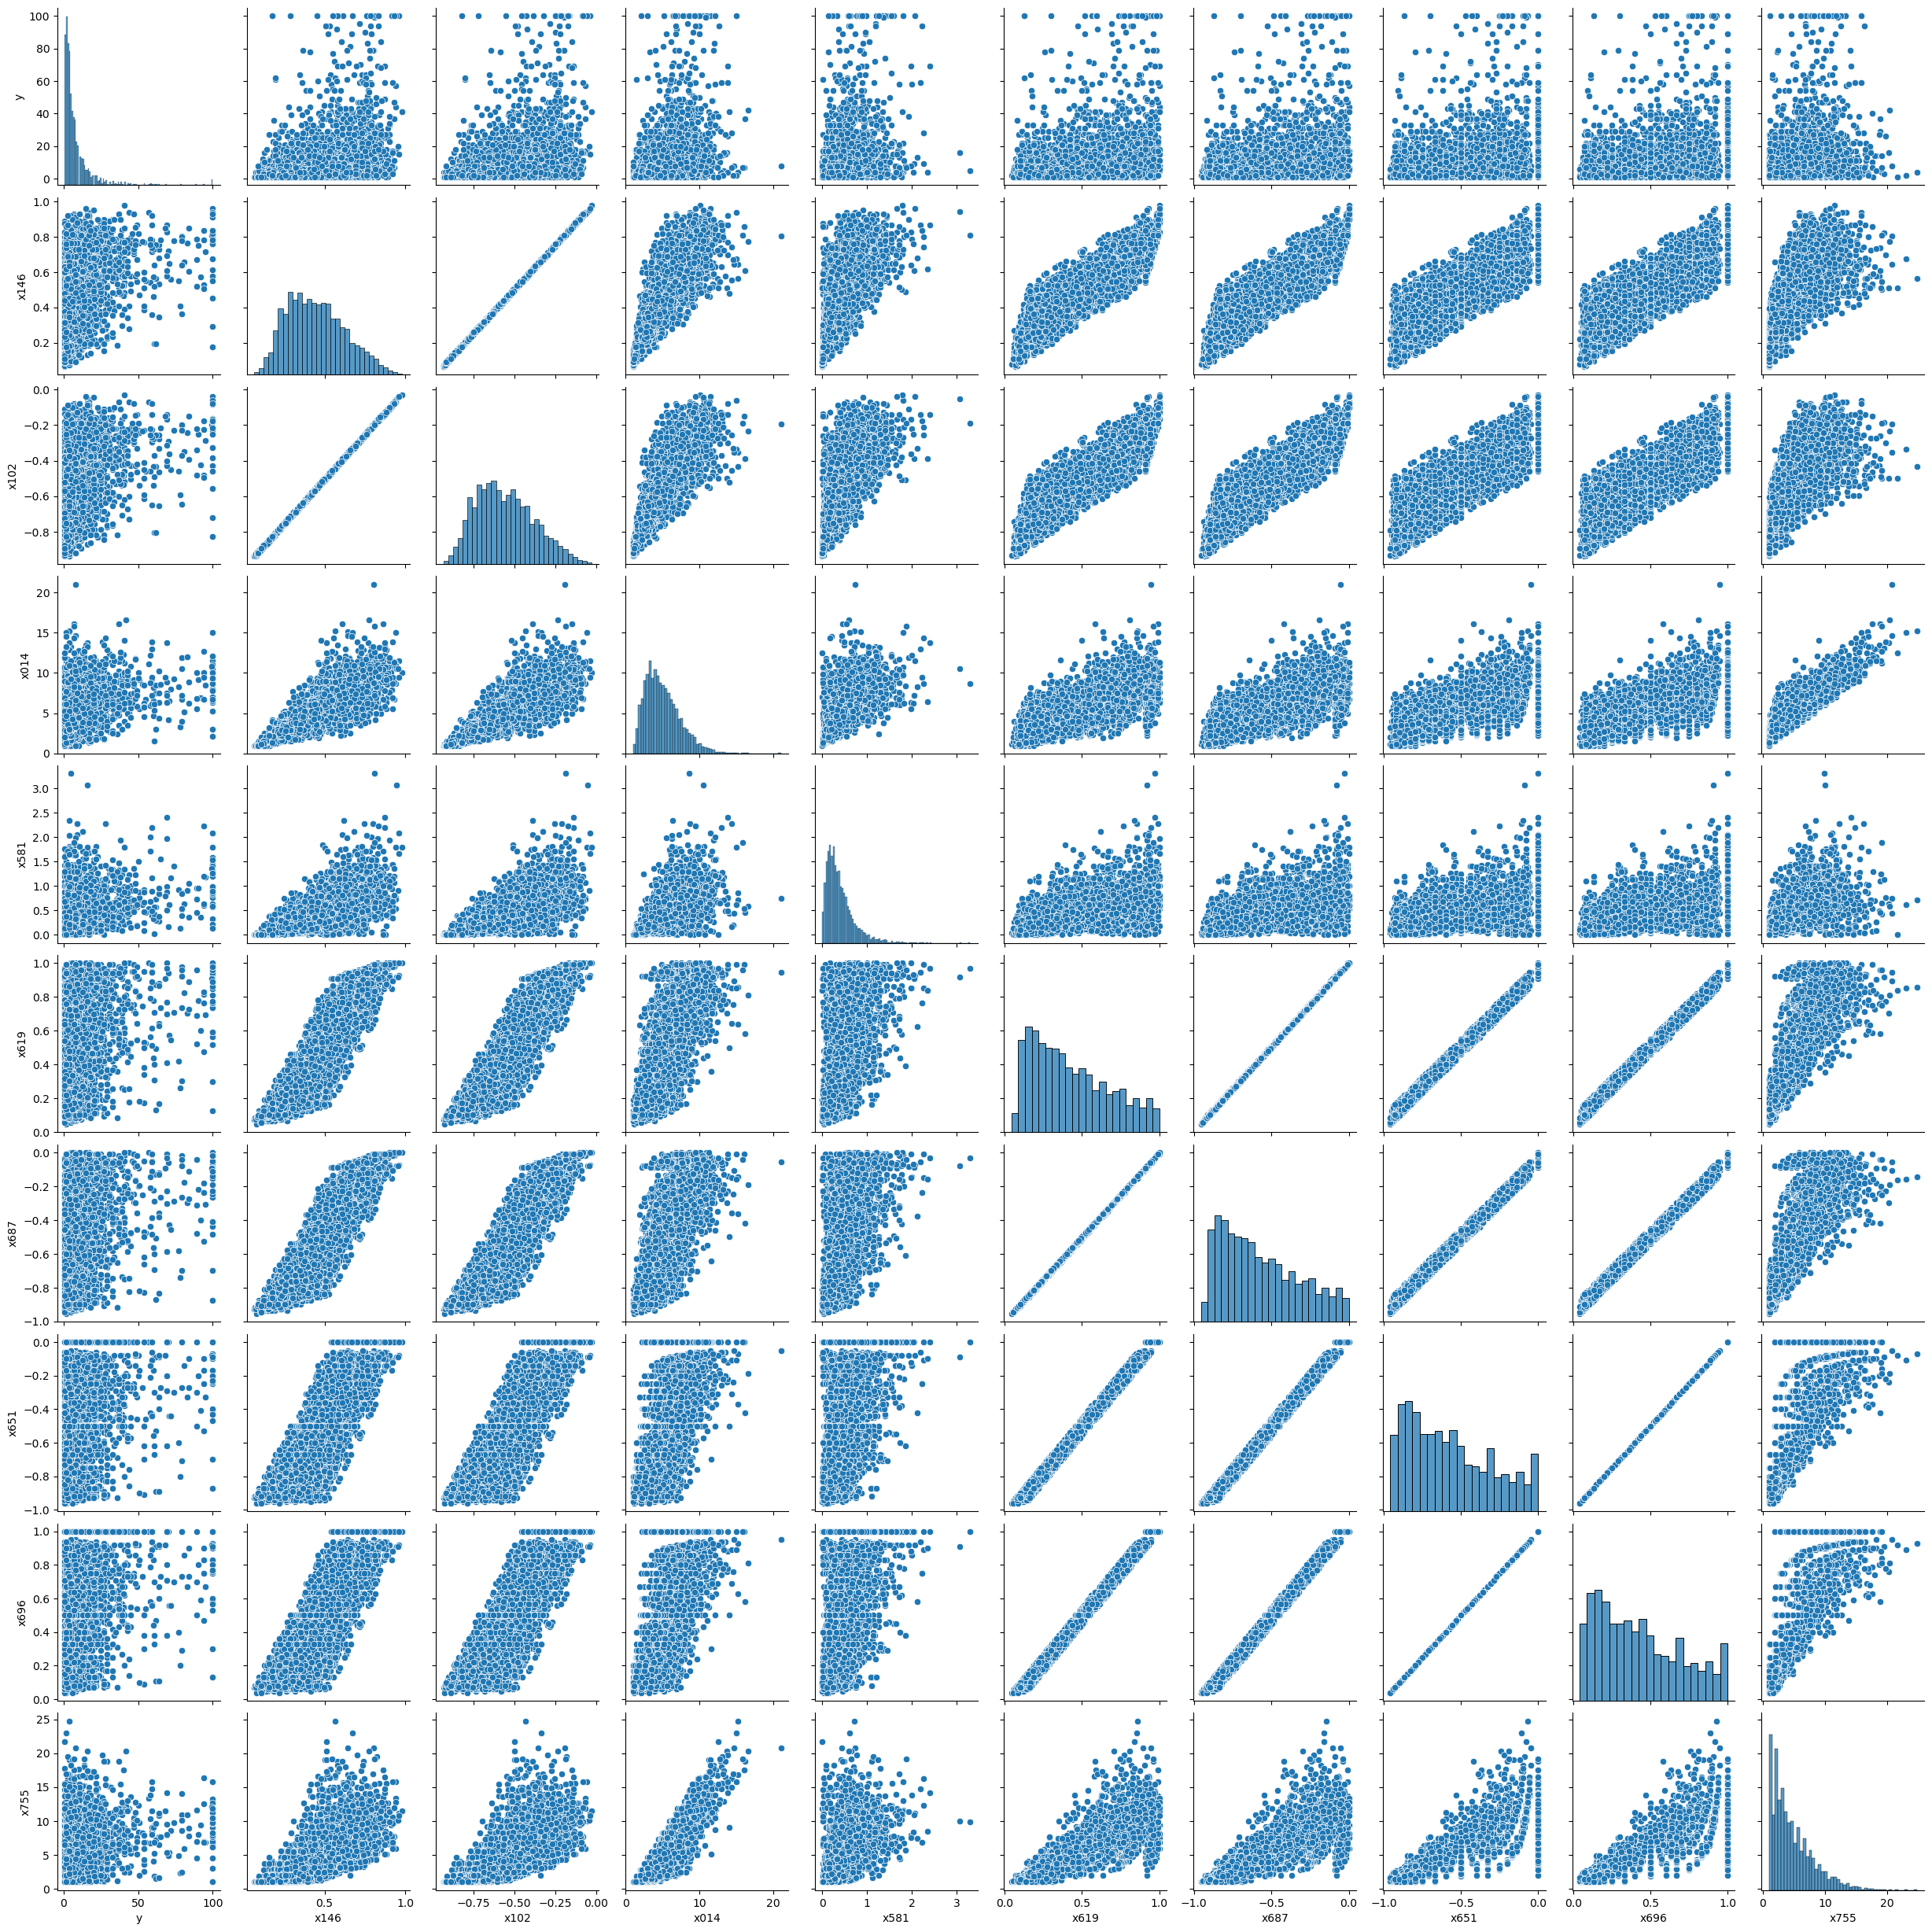

In [7]:
sns.pairplot(top_corr)

Observations: 
1. x102 and x146 are linearly corrrelated.
2. x619 is linearly correlated with 696, 651, 687
2. x687 is linearly correlated with x619, x651, x696
3. x651 is linearly correlated with x696, x687, 619
4. Many other linear correlations, some correlations also look exponential?

In [602]:
train1

id          x001      x002  x003     x004          x005  x006  \
0        0.0  9.681860e+10   6991.15  7.76  0.00380  5.378811e+09  0.31   
1        1.0  3.304810e+09  13914.43  5.37  0.00015  1.652405e+09  0.00   
2        2.0  3.218944e+10   3991.98  5.77  0.00010  2.476111e+09  0.00   
3        3.0  1.288000e+10  15937.45  5.86  0.00020  2.146667e+09  0.00   
4        4.0  3.063412e+10   3621.00  7.52  0.00060  1.392460e+09  0.21   
...      ...           ...       ...   ...      ...           ...   ...   
5375  5375.0  3.948791e+09  24563.46  6.73  0.00035  9.871977e+08  0.43   
5376  5376.0  9.279017e+10  21572.94  6.96  0.00120  3.093006e+09  0.30   
5377  5377.0  2.700359e+10  23061.73  6.36  0.00065  3.857656e+09  0.35   
5378  5378.0  4.351107e+10   5739.04  7.80  0.00065  1.318517e+09  0.29   
5379  5379.0  3.972951e+09   3368.55  6.15  0.00000  1.324317e+09  0.00   

             x007       x008       x009  ...    x756    x757          x758  \
0       266117.20   934577.0    14539.0  ...  1.5707  0.0007  2.972810e+08   
1     11927742.92  1798051.0  1051272.0  ...  0.1173  0.1136  3.320000e+12   
2       774385.01   375738.0   144143.0  ...  0.4582  0.0029  1.004748e+08   
3      6324375.16  1932094.0    10055.0  ...  0.3816  0.0000  3.480000e+11   
4       169860.29   474253.0    17914.0  ...  0.0100  0.0005  1.095466e+08   
...           ...        ...        ...  ...     ...     ...           ...   
5375   3303184.55  3154159.0     4439.0  ...  1.3758  0.0000  1.586033e+08   
5376   2649164.57  2934417.0    19106.0  ...  0.2230  0.0003  3.608917e+07   
5377   1825306.07  2395841.0    71514.0  ...  0.1300  0.0057  1.786891e+06   
5378    144103.12   715173.0    13977.0  ...  0.2719  0.0001  1.940000e+11   
5379    471263.24   419675.0     1457.0  ...  0.4605  0.0000  5.740000e+12   

      x759   x760  x761   x762     x763    x764     y  
0     0.13    5.0   5.0    2.0   8.5127   14.28   5.0  
1     0.08  661.0   0.0  350.0   1.5700  160.12   1.0  
2     0.39   39.0   2.0   18.0   9.6800   25.06  11.0  
3     0.25    2.0   1.0    0.0   4.5316  117.76   1.0  
4     0.11   11.0   1.0    3.0  16.2717    5.81   5.0  
...    ...    ...   ...    ...      ...     ...   ...  
5375  0.05    0.0   0.0    0.0   2.7480   93.45   4.0  
5376  0.01    6.0   4.0    4.0  23.6890   76.05   8.0  
5377  0.53   44.0   0.0   28.0   4.3710   80.30  21.0  
5378  0.29    3.0   2.0    2.0  24.6594    7.95  13.0  
5379  0.51    0.0   0.0    0.0   2.0195   19.07  28.0  

[5380 rows x 647 columns]

In [606]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = train1
X = add_constant(X)

In [607]:
X.

id          x001      x002  x003     x004          x005  x006  \
0        0.0  9.681860e+10   6991.15  7.76  0.00380  5.378811e+09  0.31   
1        1.0  3.304810e+09  13914.43  5.37  0.00015  1.652405e+09  0.00   
2        2.0  3.218944e+10   3991.98  5.77  0.00010  2.476111e+09  0.00   
3        3.0  1.288000e+10  15937.45  5.86  0.00020  2.146667e+09  0.00   
4        4.0  3.063412e+10   3621.00  7.52  0.00060  1.392460e+09  0.21   
...      ...           ...       ...   ...      ...           ...   ...   
5375  5375.0  3.948791e+09  24563.46  6.73  0.00035  9.871977e+08  0.43   
5376  5376.0  9.279017e+10  21572.94  6.96  0.00120  3.093006e+09  0.30   
5377  5377.0  2.700359e+10  23061.73  6.36  0.00065  3.857656e+09  0.35   
5378  5378.0  4.351107e+10   5739.04  7.80  0.00065  1.318517e+09  0.29   
5379  5379.0  3.972951e+09   3368.55  6.15  0.00000  1.324317e+09  0.00   

             x007       x008       x009  ...    x756    x757          x758  \
0       266117.20   934577.0    14539.0  ...  1.5707  0.0007  2.972810e+08   
1     11927742.92  1798051.0  1051272.0  ...  0.1173  0.1136  3.320000e+12   
2       774385.01   375738.0   144143.0  ...  0.4582  0.0029  1.004748e+08   
3      6324375.16  1932094.0    10055.0  ...  0.3816  0.0000  3.480000e+11   
4       169860.29   474253.0    17914.0  ...  0.0100  0.0005  1.095466e+08   
...           ...        ...        ...  ...     ...     ...           ...   
5375   3303184.55  3154159.0     4439.0  ...  1.3758  0.0000  1.586033e+08   
5376   2649164.57  2934417.0    19106.0  ...  0.2230  0.0003  3.608917e+07   
5377   1825306.07  2395841.0    71514.0  ...  0.1300  0.0057  1.786891e+06   
5378    144103.12   715173.0    13977.0  ...  0.2719  0.0001  1.940000e+11   
5379    471263.24   419675.0     1457.0  ...  0.4605  0.0000  5.740000e+12   

      x759   x760  x761   x762     x763    x764     y  
0     0.13    5.0   5.0    2.0   8.5127   14.28   5.0  
1     0.08  661.0   0.0  350.0   1.5700  160.12   1.0  
2     0.39   39.0   2.0   18.0   9.6800   25.06  11.0  
3     0.25    2.0   1.0    0.0   4.5316  117.76   1.0  
4     0.11   11.0   1.0    3.0  16.2717    5.81   5.0  
...    ...    ...   ...    ...      ...     ...   ...  
5375  0.05    0.0   0.0    0.0   2.7480   93.45   4.0  
5376  0.01    6.0   4.0    4.0  23.6890   76.05   8.0  
5377  0.53   44.0   0.0   28.0   4.3710   80.30  21.0  
5378  0.29    3.0   2.0    2.0  24.6594    7.95  13.0  
5379  0.51    0.0   0.0    0.0   2.0195   19.07  28.0  

[5380 rows x 647 columns]

In [646]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
top_30_X = train_imputed[top_30.index.tolist()]
top_30_X = add_constant(top_30_X)
vif_data = pd.DataFrame()
vif_data["feature"] = top_30_X.columns

for i in range(len(top_30_X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(top_30_X.values, i)

print(vif_data)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


   feature           VIF
0    const  0.000000e+00
1     x146  1.284401e+03
2     x102  1.283606e+03
3     x014  9.505843e+01
4     x581  2.546202e+01
5     x619  2.758356e+04
6     x687  2.771087e+04
7     x696           inf
8     x651           inf
9     x755  1.814759e+03
10    x096  1.513916e+01
11    x756  5.215996e+02
12    x569  9.153984e+01
13    x543  1.361425e+03
14    x749  3.740677e+02
15    x591  2.500525e+07
16    x427  2.500447e+07
17    x742  1.293145e+01
18    x561  9.303636e+00
19    x488  1.703138e+03
20    x572  3.339978e+02
21    x670  2.466760e+01
22    x685  1.153500e+03
23    x239  4.739285e+01
24    x669  1.146309e+03
25    x654  2.707122e+00
26    x430  8.856143e+02
27    x355  7.737424e+01
28    x724  1.248671e+01
29    x638  3.033418e+00
30    x425  1.639302e+01


In [275]:
# inf VIF: x696/x651

### Excluding inf correlation 

In [272]:
X = top_30_X.drop(['const', 'y','x651', 'x724'], axis = 1)
test_filtered = test[X.columns]

In [273]:
model = Earth(max_terms = 500, max_degree = 1, feature_importance_type = 'rss')
model.fit(X, y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [274]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = model.predict(test_filtered)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 

### Splitting Data

### PCA

In [735]:
X_imputed = train_imputed.drop('y', axis = 1)
scaler = StandardScaler().fit(X_imputed)
data_scaled = scaler.transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

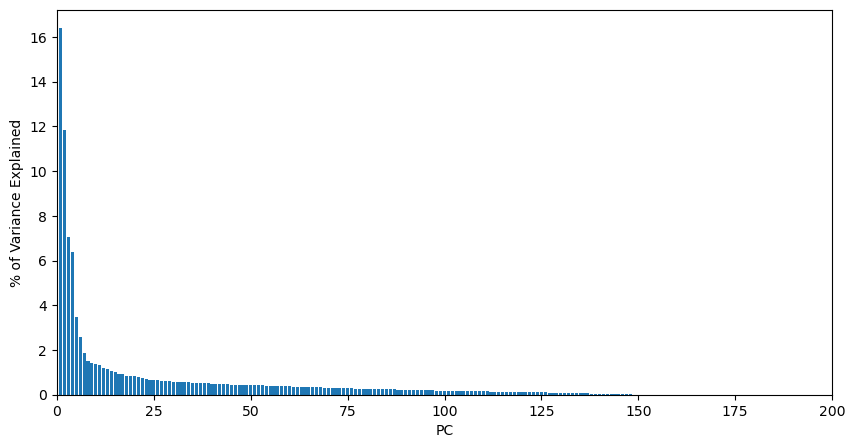

In [736]:
from sklearn.decomposition import PCA
plt.rcParams.update(plt.rcParamsDefault)
pca = PCA()
pca.fit(data_scaled)

var = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(var))+1, var*100)
plt.xlim([0, 200])
plt.xlabel('PC')
plt.ylabel('% of Variance Explained')
plt.show()

In [737]:
pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform(data_scaled)

print("No. of PCs kept:", np.sum(pca.n_components_))

No. of PCs kept: 99


In [738]:
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)
test_pca = pca.transform(test_scaled)

In [739]:
model = Earth(max_terms = 500, max_degree = 1, feature_importance_type = 'rss')
model.fit(data_pca, train_imputed['y'])

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [740]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = model.predict(test_pca)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 

## Random Forest

In [289]:
#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time

In [287]:
model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=10, random_state=1,
                        n_jobs=-1).fit(X, y)

In [298]:
feature_importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_importances

array([0.18082085, 0.1488673 , 0.12441399, 0.        , 0.0051903 ,
       0.00300099, 0.03507555, 0.        , 0.        , 0.        ,
       0.03280345, 0.0498227 , 0.        , 0.06613812, 0.0064885 ,
       0.05172346, 0.        , 0.03913741, 0.        , 0.01242072,
       0.1450127 , 0.03357802, 0.        , 0.0012665 , 0.06423943,
       0.        , 0.        ])

In [299]:
model = RandomForestRegressor(n_estimators=10, random_state=1,max_features="sqrt",max_depth=3,n_jobs=-1).fit(X, y)

In [306]:
#Finding model accuracy vs number of trees
oob_rsquared={};oob_rmse={};

for i in np.linspace(10,400,40,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared of the model
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y))

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


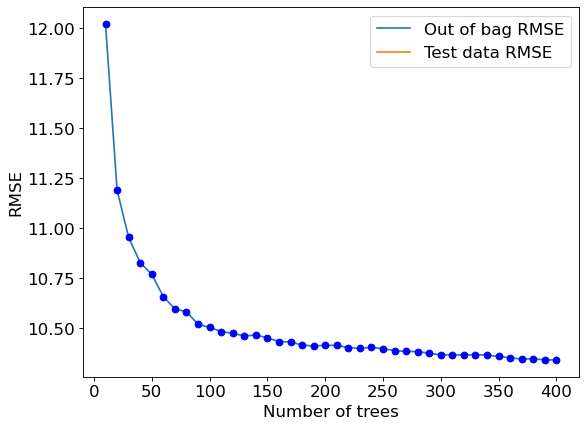

In [308]:
# rmse
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

In [309]:
#Bagging with 300 trees
model = RandomForestRegressor(n_estimators=300, random_state=1,max_features="sqrt",
                        oob_score=True,n_jobs=-1).fit(X, y)

In [311]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = model.predict(test_filtered)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 

## MARS

In [75]:
model = Earth(max_terms=500, max_degree=1) 
model.fit(X,y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(max_degree=1, max_terms=500)

In [463]:
top_corr

y   x146   x102   x014    x581   x619   x687  x696  x651   x755  ...  \
0      5  0.725 -0.285   4.82  1.0115  0.755 -0.245  0.75 -0.25   3.37  ...   
1      1  0.340 -0.660   4.00  0.2185  0.248 -0.752  0.22 -0.78   2.40  ...   
2     11  0.530 -0.470   6.62  0.3590  0.516 -0.484  0.54 -0.46   6.67  ...   
3      1  0.430 -0.570   5.60  0.2720  0.578 -0.422  0.62 -0.38   7.40  ...   
4      5  0.240 -0.760   2.43  0.1500  0.074 -0.926  0.06 -0.94   1.14  ...   
...   ..    ...    ...    ...     ...    ...    ...   ...   ...    ...  ...   
5375   4  0.635 -0.375  10.88  0.9910  0.727 -0.273  0.73 -0.27  15.10  ...   
5376   8  0.585 -0.415   5.40  0.3250  0.563 -0.437  0.57 -0.43   4.38  ...   
5377  21  0.365 -0.635   4.58  0.4700  0.187 -0.813  0.13 -0.87   1.87  ...   
5378  13  0.605 -0.405   5.68  0.2155  0.831 -0.169  0.89 -0.11   7.51  ...   
5379  28  0.810 -0.200   7.25  0.5525  0.834 -0.166  0.86 -0.14   6.29  ...   

       x572  x670  x685   x239  x669  x654   x430   x355  x118  x724  
0     5.648     6    23  6.048  5.72  0.01  5.738  27.79     6     6  
1     4.150    11    88  4.280  4.00  0.50  4.200  84.00     4     4  
2     6.935     7    40  6.535  6.85  0.00  6.855  47.40     7     7  
3     5.793     8    66  5.733  5.67  0.38  5.633  70.72     6     6  
4     5.465    14    61  5.475  5.45  0.76  5.475  57.45    14    14  
...     ...   ...   ...    ...   ...   ...    ...    ...   ...   ...  
5375  7.760     4    47  7.860  8.00  0.13  7.720  55.75     4     4  
5376  5.407     5    60  5.277  5.13  0.03  5.137  55.06     4     4  
5377  5.423    15    90  5.833  5.57  0.52  5.643  81.50    15    15  
5378  6.071    10    46  6.011  6.09  0.07  6.081  49.85    10    10  
5379  7.613    13    52  8.143  7.67  0.00  7.753  52.50    13    13  

[5380 rows x 30 columns]

In [474]:
y = top_corr['y']
X = top_corr.drop(['y'], axis = 1)

In [477]:
y.isna().any().sum()

0

In [478]:
model = Earth(max_terms = 500, max_degree = 1, feature_importance_type = 'rss')
model.fit(X, y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [479]:
print(model.summary())

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      828.898      
h(x102+0.08)     Yes     None         
h(-0.08-x102)    No      -18.5613     
h(x561-24)       No      26.4188      
h(24-x561)       No      -0.857394    
h(x355-48.81)    No      0.489477     
h(48.81-x355)    Yes     None         
h(x591+0.2367)   No      130.448      
h(-0.2367-x591)  Yes     None         
h(x488-19.26)    No      -1.25702     
h(19.26-x488)    Yes     None         
h(x355-25.97)    Yes     None         
h(25.97-x355)    No      1.10374      
h(x488-0.5)      No      -65.4448     
h(0.5-x488)      Yes     None         
h(x572-7.507)    No      12.2517      
h(7.507-x572)    No      -2.47876     
h(x430-7.65)     No      -9.98292     
h(7.65-x430)     No      2.23213      
h(x581-1.996)    No      -86.9485     
h(1.996-x581)    Yes     None         
h(x118-23)       No      -23.5817     
h(23-x118)   

In [480]:
predictor = pd.Series(X.columns, name = 'predictor')
rel_importance = pd.Series(model.feature_importances_, name = 'relative importance')
importance = pd.concat([predictor, rel_importance], axis = 1).sort_values(by = 'relative importance', ascending = False)

In [487]:
importance[0:13]

predictor  relative importance
1       x102             0.443540
17      x561             0.258697
26      x355             0.143216
14      x591             0.054034
18      x488             0.039853
25      x430             0.017263
20      x670             0.009746
19      x572             0.009583
3       x581             0.006896
2       x014             0.005210
27      x118             0.004263
8       x755             0.004118
10      x756             0.003581

In [502]:
X = train_imputed[importance['predictor'][0:5]]
X_backup = train_imputed[importance['predictor'][0:5]]

In [508]:
for combo in itertools.combinations(X_backup.columns, 2):    
    train_imputed['_'.join(combo)] = train_imputed[combo[0]]*train_imputed[combo[1]]
    test_imputed['_'.join(combo)] = test_imputed[combo[0]]*test_imputed[combo[1]]
    X.loc[:,'_'.join(combo)] = train_imputed.loc[:,'_'.join(combo)] 

/var/folders/8n/jcf8jkgd07q33yx5hgq1969r0000gn/T/ipykernel_67455/2135154182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train_imputed.loc[:,'_'.join(combo)]


In [500]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('y~' + '+'.join(predictor_subset),data = train_imputed).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [509]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 15 models on 1 predictors in 0.2682337760925293 seconds.
Processed 105 models on 2 predictors in 1.1853580474853516 seconds.
Processed 455 models on 3 predictors in 5.203746795654297 seconds.
Processed 1365 models on 4 predictors in 18.26373291015625 seconds.
Processed 3003 models on 5 predictors in 53.064796924591064 seconds.
Processed 5005 models on 6 predictors in 123.66170763969421 seconds.
Processed 6435 models on 7 predictors in 155.2197117805481 seconds.
Processed 6435 models on 8 predictors in 175.64092683792114 seconds.
Processed 5005 models on 9 predictors in 147.05920219421387 seconds.
Processed 3003 models on 10 predictors in 86.37099599838257 seconds.
Processed 1365 models on 11 predictors in 62.41696095466614 seconds.
Processed 455 models on 12 predictors in 13.305071115493774 seconds.
Processed 105 models on 13 predictors in 3.445382833480835 seconds.
Processed 15 models on 14 predictors in 0.4873342514038086 seconds.
Processed 1 models on 15 predictors in 0.03

In [504]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

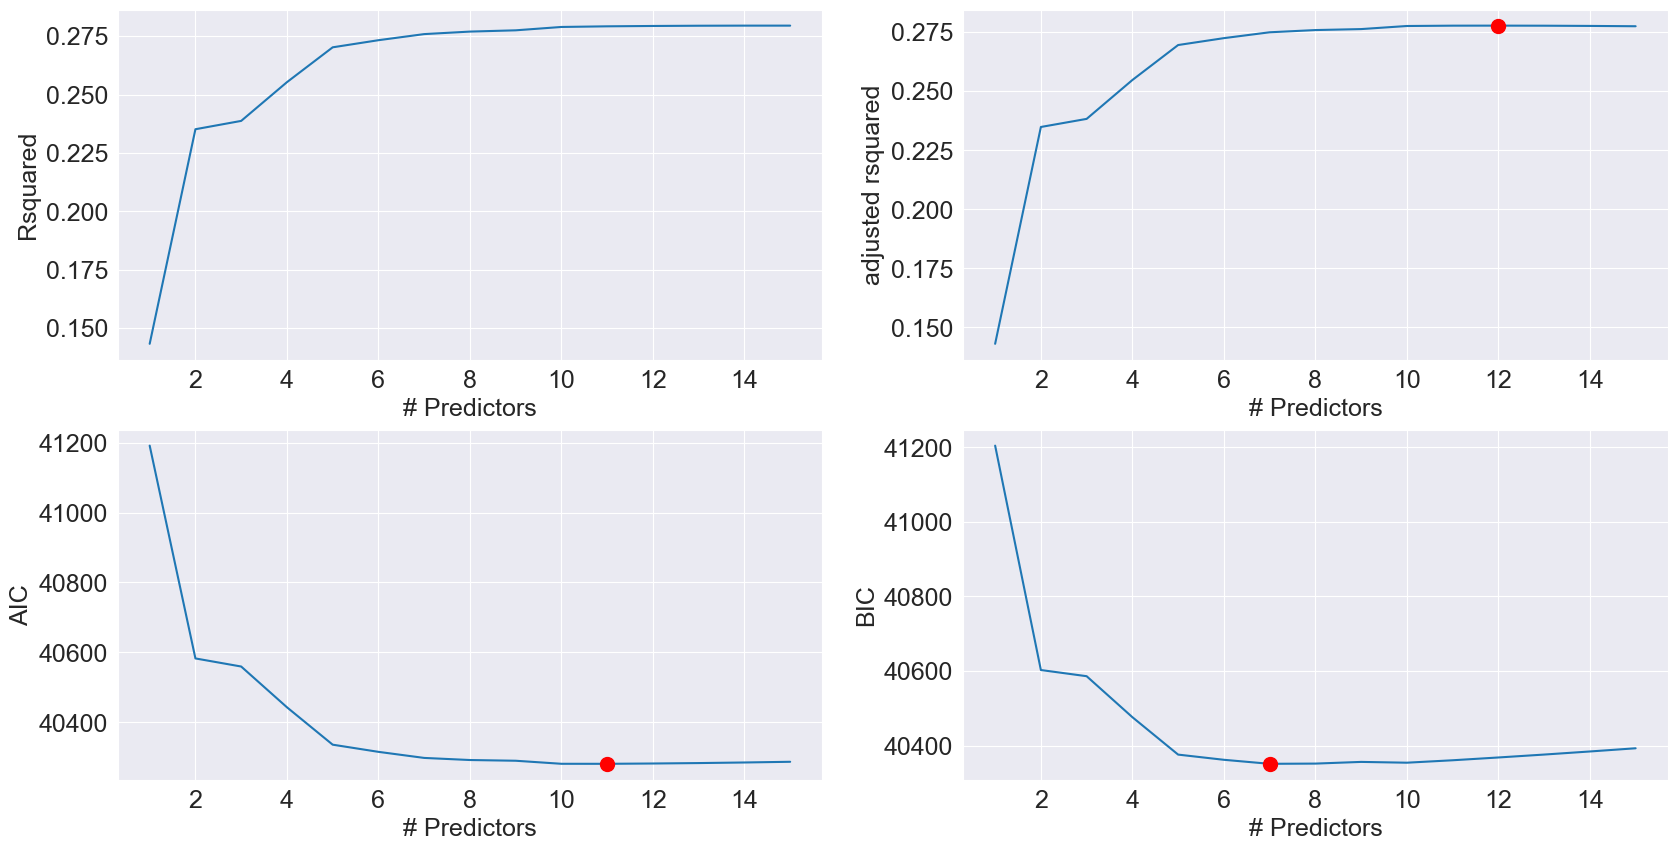

In [510]:
best_sub_plots()

In [511]:
best_subset_model = models_best.loc[7,'model']
models_best.loc[7,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     292.4
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        17:10:02   Log-Likelihood:                -20141.
No. Observations:                5380   AIC:                         4.030e+04
Df Residuals:                    5372   BIC:                         4.035e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.9395      2.274     12.288      0.000      23.482      32.397
x102          20.4691      4.649      4.403      0.000      11.355      29.584
x561           2.1777      0.138     15.822      0.000       1.908       2.448
x591          56.5861      3.529     16.034      0.000      49.668      63.504
x488          -0.2031      0.029     -7.063      0.000      -0.260      -0.147
x102_x561      2.2197      0.231      9.626      0.000       1.768       2.672
x102_x591     45.5912      7.229      6.307      0.000      31.419      59.763
x591_x488     -0.3277      0.051     -6.451      0.000      -0.427      -0.228
==============================================================================
Omnibus:                     4291.434   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120957.826
Skew:                           3.649   Prob(JB):                         0.00
Kurtosis:                      25.053   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# interaction terms: x102*x591, x102*x561, x591*x488`

In [526]:
importance['predictor'][0:13].tolist()

['x102',
 'x561',
 'x355',
 'x591',
 'x488',
 'x430',
 'x670',
 'x572',
 'x581',
 'x014',
 'x118',
 'x755',
 'x756']

In [533]:
columns = importance['predictor'][0:13].tolist()
interaction_terms = ['x102_x591', 'x102_x561', 'x591_x488']
columns.extend(interaction_terms)
print(columns)

['x102', 'x561', 'x355', 'x591', 'x488', 'x430', 'x670', 'x572', 'x581', 'x014', 'x118', 'x755', 'x756', 'x102_x591', 'x102_x561', 'x591_x488']


In [538]:
X = train_imputed[importance['predictor'][0:13].tolist()]
y = train_imputed['y']
test_X = test_imputed[X.columns]

In [540]:
model = Earth(max_terms = 500, max_degree = 1, feature_importance_type = 'rss')
model.fit(X, y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [541]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = model.predict(test_X)
pred = pred.set_index(['id']) # 10.01 on Kaggle

In [542]:
pred.to_csv('Witarsa_Ashley_regression.csv') 

In [543]:
preds = pd.DataFrame()
train = pd.concat([y, X], axis = 1)
for ii in range(10):
    train_sample = train.sample(n = len(X), random_state = ii, replace = True)
    y_train_sample = train_sample.y
    X_train_sample = train_sample.drop('y', axis = 1)
    model = Earth(max_terms = 500, max_degree = 1)
    model.fit(X_train_sample, y_train_sample)
    pred = model.predict(test_X)
    preds[ii] = pred

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

In [545]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = np.mean(preds, axis = 1)
pred = pred.set_index(['id'])

In [546]:
pred.to_csv('Witarsa_Ashley_regression.csv') # 9.976

### GAM

In [552]:
# Train 4 MARS models with deg 1, 2, 3, 4
mars1 = Earth(max_terms = 500, max_degree = 1)
mars2 = Earth(max_terms = 500, max_degree = 2)
mars3 = Earth(max_terms = 500, max_degree = 3)
mars4 = Earth(max_terms = 500, max_degree = 4)
mars1.fit(X, y)
mars2.fit(X, y)
mars3.fit(X, y)
mars4.fit(X, y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

Earth(max_degree=4, max_terms=500)

In [557]:
gam_preds = pd.DataFrame()
gam_preds['beta_1'] = mars1.predict(X)
gam_preds['beta_2'] = mars2.predict(X)
gam_preds['beta_3'] = mars3.predict(X)
gam_preds['beta_4'] = mars4.predict(X)
gam_model = LinearRegression()
gam_model.fit(gam_preds, y)

LinearRegression()

In [558]:
gam_test_preds = pd.DataFrame()

gam_test_preds['beta_1'] = mars1.predict(test_X)
gam_test_preds['beta_2'] = mars2.predict(test_X)
gam_test_preds['beta_3'] = mars3.predict(test_X)
gam_test_preds['beta_4'] = mars4.predict(test_X)

gam_test_pred = gam_model.predict(gam_test_preds)

In [559]:
train = pd.concat([y, X], axis = 1)
preds = pd.DataFrame()
for ii in range(10):
    train_sample = train.sample(n = len(train), random_state = ii, replace = True)
    y_train_sample = train_sample.y
    X_train_sample = train_sample.drop('y', axis = 1)
    
    # Creating models
    model1 = Earth(max_terms = 500, max_degree = 1)
    model2 = Earth(max_terms = 500, max_degree = 2)
    model3 = Earth(max_terms = 500, max_degree = 3)
    model4 = Earth(max_terms = 500, max_degree = 4)
    
    # Fitting models
    model1.fit(X_train_sample, y_train_sample)
    model2.fit(X_train_sample, y_train_sample)
    model3.fit(X_train_sample, y_train_sample)
    model4.fit(X_train_sample, y_train_sample)
    
    # Betas
    gam_preds = pd.DataFrame()
    gam_preds['beta_1'] = model1.predict(test_X)
    gam_preds['beta_2'] = model2.predict(test_X)
    gam_preds['beta_3'] = model3.predict(test_X)
    gam_preds['beta_4'] = model4.predict(test_X)
    
    pred = gam_model.predict(gam_preds)
    preds[ii] = pred

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


KeyboardInterrupt: 

##### Random Forest based on above

In [547]:
model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=10, random_state=1,
                        n_jobs=-1).fit(X, y)

In [548]:
oob_rsquared={};oob_rmse={};

for i in np.linspace(10,400,40,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared of the model
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y))

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


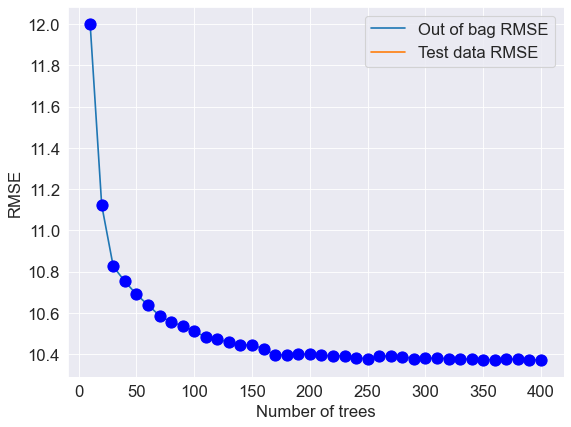

In [549]:
# rmse
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()